## Known issues need to handle:
1. 某些檔案的中文字會在linux下跑掉，導致姓名、學校抓不到<br>
如：'完整審查資料/10246806/10246806.pdf'
... 已證實並非linux或任何編碼問題，在pdf專門的檢視器中都是顯示正常中文，但只要複製貼上就會變錯誤的中文。我猜是某種pdf的保護機制。
2. 中文字無法parse變成\x10這種鬼東西，應該只能用ocr去處理

In [1]:
import pdftotext
import re
import regex
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm


In [2]:
test_pdf_files = ['additional_tables/' + i for i in os.listdir('additional_tables')]

In [74]:
with open(test_pdf_files[1],"rb") as f:
    pdf = pdftotext.PDF(f)
for page in pdf:
    if '大學個人申請入學第二階段審查資料' in page:
        table_page = page
table_page

'                       國立宜蘭大學 外國語文 學系\n         大學個人申請入學第二階段審查資料考生個人資料表\n 填表注意事項：\n 1. 請將本表填妥後一併整合至您的個人申請入學書面審查資料「自傳」項目中，並依規定上傳至大學甄\n    選委員會書面審查上傳系統之"自傳"類別。\n 2. 本系對資料內容保密，但在必要時將對資料內所提及的事實進行查核，若發現虛偽造假之情事，將會\n    影響您的錄取機會。情節嚴重者，並將由本系甄試委員會認定後，報請本校招生委員會取消錄取資格。\n 3. 個人資料表中提到之證明文件，請依簡章規定，於大學甄選入學委員會網路上傳審查資料時，一併上\n    傳證明文件。\n 4. 填答時，若覺空間不足，請自行增附頁數，並在相關題目或欄位中說明即可。\n 5. 如未曾參與或無法回答的問題，請在相關欄位後填「無」即可。\n                                                    填表日期：108 年 3 月 27 日\n基   姓名：田芮綺                 性別：\uf063男   ■女       學測應試號碼：10317439\n本\n資\n料   就讀學校：_私立海星高級中學_\n          學期平       班排名次    名次百分比  類組(類科)排    名次百分比 校排名次       名次百分比\n      學期\n          均成績        ／人數     （％）    名次／人數       （％）   ／人數        （％）\n     高一上   70.60     22/38    58     61/108      56\n     高一下   76.00     16/38    42     42/108      39\n     高二上   67.70     27/38    71     65/108      60\n在\n校    高二下   69.80     22/38    58     56/108      52\n成\n績\n     高三上   61.70     28/38    74     65/108      60\n      科目     

In [76]:
tt = re.findall('擇最佳成績填入\)\n([\s\S]+)\n    一、您為何選擇本系就讀？',table_page)[0]
('公民' in tt) or ('生涯' in tt)
# tt = re.split(' +',tt.replace('\n',''))
# rest = [tt[2],float(tt[3]),tt[4],float(tt[5]),tt[1]+tt[-1],float(tt[-2])]
# rest

True

In [72]:
'公民' in tt

False

In [77]:
def additional_table_parser(table_txt):
    output = []
    name = re.findall('就讀學校：(.*?)\n',table_txt)[0].replace('_','')
    school = re.findall('姓名：(.*?)性',table_txt)[0].replace(' ','')
    output += [name,school]
    for i in ['一上','一下','二上','二下','三上']:
        tt = re.findall(f'高{i}(.*?)\n',table_txt)[0]
        tl = [round(eval(j),2) for j in re.findall('\d{1,3}/\d{2,3}',tt)]
        if len(tl) < 3:
            class_year = False
            for c in re.findall('( +)',tt):
                '''
                check how long the space is to determine the missing...
                so dirty...
                '''
                if len(c) > 10:
                    class_year = True
                    break
            if class_year:
                output += [tl[0],np.nan,tl[1]]
            elif len(tl) == 2:
                output += [tl[0],tl[1],np.nan]
            else:
                output += [tl[0],np.nan,np.nan]
        else:
            output += tl;

    output = [output[i] for i in [0,1,2,5,8,11,14,3,6,9,12,15,4,7,10,13,16]]
    tt = re.findall('擇最佳成績填入\)\n([\s\S]+)\n    一、您為何選擇本系就讀？',table_page)[0]
    if ('公民' in tt) or ('生涯' in tt):
        '''
        土木系與外文系
        '''
        tt = re.split(' +',tt.replace('\n',''))
        rest = [tt[2],float(tt[3]),tt[4],float(tt[5]),tt[1]+tt[-1],float(tt[-2])]
    else:
        tt = re.split(' +',tt.replace('\n',''))[1:]            
        rest = [float(tt[i]) if i%2 == 1 else tt[i] for i in range(len(tt))]
        
    while len(rest) < 6:
        '''
        生機系: len(tt) == 4 else 6
        '''
        rest.append(np.nan)
        
    output += rest
    return output
            
    

In [78]:
O = []
for file in test_pdf_files:
    with open(file, 'rb') as f:
        pdf = pdftotext.PDF(f)
    if len(pdf) < 4:
        print('This file is so wierd.')
        continue
    for i, page in enumerate(pdf):
        if '大學個人申請入學第二階段審查資料' in page:
            table_page = page
            break
    else:
        print('This file does not contain our target table!')
        print(file)
        print('***************************************')
        continue
    try:
        O.append(additional_table_parser(table_page))
    except Exception as e:
        print(e)
        print(file)            

In [79]:
pd.DataFrame(O)

0    1     2     3     4     5     6     7     8     9   ...   \
0    高雄市立三民高級中學  李姿頴  0.12  0.15  0.28  0.18  0.05  0.09  0.17  0.48  ...    
1      私立海星高級中學  田芮綺  0.58  0.42  0.71  0.58  0.74  0.56  0.39  0.60  ...    
2      華僑高級中等學校  吳鴻明  0.46  0.73  0.70  0.75  0.70   NaN   NaN   NaN  ...    
3  桃園市立壽山高級中等學校  陳杰民  0.36  0.50  0.34  0.49  0.20  0.32  0.47  0.36  ...    
4    新竹縣立六家高級中學  賴德揚  0.54  0.39  0.74  0.97  1.00   NaN   NaN   NaN  ...    

     13    14    15    16  17    18  19    20     21    22  
0  0.18  0.37  0.31  0.18  生物  79.0  化學  68.0     國文  89.0  
1   NaN   NaN   NaN   NaN  英文  71.0  國文  85.0  公民與社會  80.0  
2   NaN   NaN   NaN   NaN  數學  87.0  物理  76.0    NaN   NaN  
3  0.46  0.47  0.64  0.28  國文  53.4  英文  93.2     數學  80.5  
4  0.28  0.34  0.57  0.70  數學  76.0  物理  72.0     英文  74.0  

[5 rows x 23 columns]

In [157]:
additional_table_parser('additional_tables/10119812_test.pdf')

IndexError: list index out of range

In [124]:
for k  in range(5):
    print([len(i) for i in re.findall('( +)',O[k][0])])
    print(O[k])

[3, 6, 5, 5, 7, 5, 6]
['高一上   81.4      4/34     9     17/182       9     57/408      14\n', '高一下   79.7      5/34    12     31/181      17     72/404      18\n', '高二上   72.8     11/39    26     54/113      48    148/404      37\n', '高二下   75.6      7/38    16     43/112      38    125/403      31\n', '高三上   77.7      2/37     3     14/110      13     73/402      18\n']
[3, 5, 4, 5, 6]
['高一上   70.60     22/38    58     61/108      56\n', '高一下   76.00     16/38    42     42/108      39\n', '高二上   67.70     27/38    71     65/108      60\n', '高二下   69.80     22/38    58     56/108      52\n', '高三上   61.70     28/38    74     65/108      60\n']
[3, 5, 4]
['高一上   72.4     17/37    45\n', '高一下   67.4     27/37    73\n', '高二上   67.0     31/44    70\n', '高二下   66.6     33/44    75\n', '高三上   61.9     31/44    70\n']
[3, 6, 4, 5, 6, 4, 7]
['高一上   74.2      15/42    34     67/207      32    138/411       34\n', '高一下   69.9      21/42    48     97/206      47    188/410       46\n', '高二上   70.2 

In [2]:
upper_most = 'CAAC審查資料PDF'
all_pdf_files = [ f'{upper_most}/{i}/{j}/{j}.pdf' for i in os.listdir(upper_most) for j in os.listdir(upper_most+'/'+i) ]
#all_pdf_files

In [3]:
len(all_pdf_files)

704

In [23]:
for f in all_pdf_files:
    with open(all_pdf_files[0], "rb") as f:
        pdf = pdftotext.PDF(f)
    
    print(len(pdf))


13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1

In [4]:
all_pdf_files

['CAAC審查資料PDF/150032/10147427/10147427.pdf',
 'CAAC審查資料PDF/150032/10221922/10221922.pdf',
 'CAAC審查資料PDF/150032/10090318/10090318.pdf',
 'CAAC審查資料PDF/150032/10000505/10000505.pdf',
 'CAAC審查資料PDF/150032/10027504/10027504.pdf',
 'CAAC審查資料PDF/150032/10118826/10118826.pdf',
 'CAAC審查資料PDF/150032/10047114/10047114.pdf',
 'CAAC審查資料PDF/150032/10244217/10244217.pdf',
 'CAAC審查資料PDF/150032/10106910/10106910.pdf',
 'CAAC審查資料PDF/150032/10138734/10138734.pdf',
 'CAAC審查資料PDF/150032/10121140/10121140.pdf',
 'CAAC審查資料PDF/150032/10066227/10066227.pdf',
 'CAAC審查資料PDF/150032/10016532/10016532.pdf',
 'CAAC審查資料PDF/150032/10290728/10290728.pdf',
 'CAAC審查資料PDF/150032/10091427/10091427.pdf',
 'CAAC審查資料PDF/150032/10012409/10012409.pdf',
 'CAAC審查資料PDF/150032/10071702/10071702.pdf',
 'CAAC審查資料PDF/150032/10146231/10146231.pdf',
 'CAAC審查資料PDF/150032/10108726/10108726.pdf',
 'CAAC審查資料PDF/150032/10008220/10008220.pdf',
 'CAAC審查資料PDF/150032/10097337/10097337.pdf',
 'CAAC審查資料PDF/150032/19250206/19250206.pdf',
 'CAAC審查資料

1/36 完成 建立一種pattern，指符合1/36 !!! (惠文高中)
### 新北市立新莊高級中學 跳過～～  沒有學期的排名這種東西

In [4]:
def score_sheet_parser(file):
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    
    '''
    handling ocr-requried
    '''
    if pdf[2] == '':
        print(f'{file}: This file is protected, no way to parse except ocr!')
        return 'Ocr required'
    
    if ('\x10' in pdf[2]) or ('\u2e4e' in pdf[2]):
        print(f'{file}: This file has severe codex issue, no way to parse except ocr!')
        return 'Ocr required'
    
    '''
    pattern 1 EX: 惠文高中
    '''
    try:
        output = []        
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        score_sheet = pdf[2]
        output += re.findall('姓名：(\w{2,3})',score_sheet)
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))
        for s in ['班排','群排','年排']:
            output += [round(eval(i),3)for i in re.findall('\d{1,3}/\d{2,3}',re.findall(s+'(.*?\n)',score_sheet)[0])]
        
        output.append('Complete pattern 1')
        return output
    
    except:
        pass
    
    '''
    pattern 2 ex: 臺北市立和平高級中學
    '''
    try:
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])


        score_sheet = pdf[2]
        output.append(re.findall('姓 名(.*?)班',score_sheet)[0].replace(' ',''))
        school = score_sheet[20:80].replace(' ','')
        if school == '':
            school = re.findall('目前成績(.*?)申請入學',score_sheet)[0].replace(' ','')
        output.append(school)
        try:
            L = re.split(' +',re.findall('\n學業成績(.*?)\n',score_sheet)[0])[1:]
        except:
            L = re.split(' +',re.findall('\n學業成績(.*?)\n',pdf[3])[0])[1:]
        try:
            PL = re.split(' +',re.findall('\n總人數(.*?)\n',score_sheet)[0])[1:]
        except:
            PL = re.split(' +',re.findall('\n總人數(.*?)\n',pdf[3])[0])[1:]
        RL = [L[i] for i in [1,2,3,8,9,10,15,16,17,22,23,24,29,30,31]]
        TL = [round(eval(i+'/'+j),3) for i,j in zip(RL,PL)]
        for i in range(3):
            output += TL[i::3]
            
        output.append('Complete pattern 2')
        return output    
        
    except:
        pass
    '''
    pattern 3 ex: 高雄市立中正高級中學
    '''
    try:
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        score_sheet = pdf[2]
        name = re.findall('姓名： (\w*?) ',score_sheet)
        if name:
            output += name
        else:
            output.append('XXX')
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))
        output += [round(eval(i),3) for i in re.findall('\d{1,3}/\d{2,3}',re.findall('班級人數 百分比(.*?)符號註記',score_sheet)[0])]
        output += [round(eval(i),3) for i in re.findall('\d{1,3}/\d{2,3}',re.findall('類組排名/類組人數(.*?)為不及格',score_sheet)[0])]
        output += [round(eval(i),3) for i in re.findall('\d{1,3}/\d{2,3}',re.findall('年級排名/年級人數(.*?)M 為重修',score_sheet)[0])]
        
        output.append('Complete pattern 3')
        return output 
    except:
        pass
    
            
    '''
    中文複製貼上會錯亂的pattern pattern4
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        try:
            output.append(re.findall('姓名：(.*?)\n',pdf[0])[0].replace(' ',''))
            output += re.findall('學校：(\w*?) ',score_sheet[0:100])
            for p in ['班','組','年級']:
                output += [round(float(i)/100,2) for i in re.findall('\d{1,3}\.\d{2,3}',re.findall(f'{p}百身比(.*){p}百身比',score_sheet)[0])]
            output.append('Complete pattern 4-1')
        except:
            output += re.findall('姓名 +(.*?) +性別',score_sheet)
            output += re.findall('學校：(.*?) ',score_sheet)
            for p in ['班','組','年級']:
                if p == '班':
                    output += [round(float(i)/100,2) for i in regex.findall(' (\d.*?) ',re.findall(f'{p}百分比(.*){p}百分比',score_sheet)[0],overlapped=True)[1::2]] 
                else:
                    output += [round(float(i)/100,2) for i in re.findall(' (\d.*?) ',re.findall(f'{p}百分比(.*){p}百分比',score_sheet)[0])] 
    
            output.append('Complete pattern 4')

        return output
    except:
        pass
    
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        output.append(re.findall('姓名：(.*?)\n',pdf[0])[0].replace(' ',''))
        output += ['XXX']
        output += [round(float(i)/100,2) for i in re.findall('\d{1,3}\.\d{2,3}',re.findall('班百身比(.*)班百身比',score_sheet)[0])[1::2]] 
        output += [round(float(i)/100,2) for i in re.findall(' (\d.*?) ',re.findall('組百身比(.*)組百身比',score_sheet)[0])] 

        for p in ['學級','學國','學揚']:
            try:
                output += [round(float(i)/100,2) for i in re.findall(' (\d.*?) ',re.findall(f'{p}百身比(.*){p}百身比',score_sheet)[0])]                 
                if len(output) != 19:
                    print('Very special case...')
                    return 'skipped'
                output.append('Complete pattern 4-2')
                return output
            except:
                pass
    except:
        pass
    
    '''
    pattern 5
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        output += re.findall('姓名：(\w*?) ',score_sheet)
        output.append(re.findall('(.*?)學生',score_sheet)[0].replace(' ',''))
        if '類組(科別)排名' not in score_sheet:
            score_sheet = pdf[3]

        for p in ['班級','類組\(科別\)','年級']:
            output += [round(eval(i),2) for i in re.findall('\d{1,3}/\d{2,3}',re.findall(p+'排名(.*?)\n',score_sheet)[0])]
        
        output.append('Complete pattern 5')
        return output
    except:
        pass
    
    '''
    pattern 6
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(\w.*?)  ',score_sheet)
        output += ['XXX']
        temp = []
        for i in range(1,4):
            tl = re.split(' +',re.findall('學業平均(.*?)\n',score_sheet)[0].split('│')[i])
            if i == 3:
                temp += [tl[j] for j in [4,8,6]]
            else:
                temp += [tl[j] for j in [4,8,6,11,15,13]]
        for i in range(3):
            output += [round(float(i)/100,2) for i in temp[i::3]]
        
        output.append('Complete pattern 6')
        return output

    except:
        pass
    
    '''
    pattern 7
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        output += re.findall('姓名： (\w*?) ',score_sheet)
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))

        for p in ['班級','學程','年級']:
            output += [round(eval(i),2) for i in re.findall('\d{1,3}/\d{2,3}',re.findall(p+'排名(.*?)\n',score_sheet)[0])]
        
        output.append('Complete pattern 7')
        return output
    except:
        pass
    
    '''
    pattern 8 
    a format very similar to the dominant skipped ones, however, 
    it contains one additional line to show all required info
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])

        output.append(re.findall('姓名：(\w*?) ',score_sheet)[0])
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))
        for p in ['班','類','校']:
            output += [int(i)/100 for i in re.findall(' (\d\d) ',re.findall('各學期成績校排(.*?)\n',score_sheet)[0])]
        
        output.append('Complete pattern 8')
        return output
    except:
        pass

    
    '''
    Skipped files
    '''
    score_sheet = pdf[2]
    for p in ['個人成績單暨班級百分比對照表','個人成績單暨百分比對照表',
              '個人成績單暨類組百分比對照表','學生個人成績單暨百分比對',
             '個人成績單暨年級百分比對照表']:
        if p in score_sheet[0:120]:
            print('This is a type of score sheet that doesnot contain enough info')
            return 'skipped'

    if (' 成績證明書\n' in score_sheet[0:120]) or \
    ('學生個人成績證明書\n' in score_sheet[0:120]) \
    or ('學 生 成 績 表' in score_sheet)\
    or ('成績一覽表' in score_sheet)\
    or ('學生個人成績單\n' in score_sheet[0:120]) \
    or ('成 績 報 告 單' in score_sheet[0:300]) \
    or ('歷年成績單-補考、重修後' in score_sheet[:300]) \
    or ('桃園市新興高級中等學校' in score_sheet[:300]):
        print('This is a type of score sheet that doesnot contain enough info')
        return 'skipped'
    
    '''
    Nothing matched at all, return False
    '''
    print('No pattern matched!')
    return False
         

In [7]:
columns = ['準考號碼','姓名','學校',
           '一上班排','一下班排','二上班排','二下班排','三上班排',
           '一上組排','一下組排','二上組排','二下組排','三上組排',
           '一上校排','一下校排','二上校排','二下校排','三上校排']

In [214]:
columns = ['系所代碼','準考號碼','姓名','學校',
           '一上班排','一下班排','二上班排','二下班排','三上班排',
           '一上組排','一下組排','二上組排','二下組排','三上組排',
           '一上校排','一下校排','二上校排','二下校排','三上校排',
           'ParserPattern']

In [12]:
DD = []
S,Skip,Ocr,F = 0,0,0,0
Failed_files = []
Skipped_files = []
Ocr_files = []
start = time.time()
for f in all_pdf_files:
    R = score_sheet_parser(f)
    if type(R) == list:
        if len(R) != 19:
            print(f)
            break
        DD.append(R)
        S += 1
        
    elif R == 'skipped':
        Skipped_files.append(f)
        Skip += 1
    elif R == 'Ocr required':
        Ocr_files.append(f)
        Ocr += 1
    else:
        Failed_files.append(f)
        F += 1
else:
    print('Done!')

print('*****************************')
print('Success:')
print(S,'/',len(all_pdf_files))
print('Skipped:')
print(Skip,'/',len(all_pdf_files))
print('Ocr required:')
print(Ocr,'/',len(all_pdf_files))
print('Failed:')
print(F,'/',len(all_pdf_files))
print(f'Runtime: {round(time.time() - start,2)}')

Very special case...
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
CAAC審查資料PDF/150032/10138734/10138734.pdf: This file is protected, no way to parse except ocr!
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 5!
Parser Pattern matched for pattern 3!
Parser Pattern matched for pattern 5!
CAAC審查資料PDF/150032/10012409/10012409.pdf: This file is protected, no way to parse except ocr!
CAAC審查資料PDF/150032/10071702/10071702.pdf: This file has severe codex issue, no way to parse except ocr!
Parser Pattern matched for pattern 3!
Parser Pattern matched for pat

This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 4-2!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
No pattern matched!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 3!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 5!
Parser Pattern matched for pattern 2!
CAAC審查資料PDF/150152/10072004/10072004.pdf: This file has severe codex issue, no way to parse except ocr!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for 

No pattern matched!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 5!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 7!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 5!
This is a type of score sheet that doesnot contain enough info
No pattern matched!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 3!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 8!
Parser Pattern matched for pattern 5!
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet that doesnot contain enough info
This is a typ

Parser Pattern matched for pattern 8!
Parser Pattern matched for pattern 4-2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 6!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
CAAC審查資料PDF/150102/10224208/10224208.pdf: This file is protected, no way to parse except ocr!
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet that doesnot contain enough info
CAAC審查資料PDF/150102/10122821/10122821.pdf: This file has severe codex issue, no way to parse except ocr!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
This is a type of score sheet

Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 4-2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 3!
Parser Pattern matched for pattern 6!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 5!
Parser Pattern matched for pattern 2!
No pattern matched!
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
Parser Pattern matched for pattern 6!
This is a type of score sheet that doesnot contain enough info
Parser Pattern matched for pattern 2!
CAAC審

Success:
388 / 704
Skipped:
261 / 704
Ocr required:
33 / 704
Failed:
22 / 704
Runtime: 261.59

In [13]:
complete_DD = DD.copy()
Skipped_files_copy = Skipped_files.copy()

# parse with missing

## Run test

In [27]:
for i in DD:
    if len(i) != 19:
        print(i)
        print(len(i))

## Handling pandas df

In [11]:
df = pd.DataFrame(DD,columns=columns)
df

系所代碼      準考號碼   姓名                                 學校  一上班排  一下班排  \
0    150032  10221922  蔡孟融             國立虎尾高級中學學生個人成績單暨百分比對照表  0.51  0.20   
1    150032  10118826  藍于喬             桃園市立陽明高中學生個人成績單暨百分比對照表  0.44  0.51   
2    150032  10244217  顏韶瑩           國立台南第二高級中學學生個人成績單暨百分比對照表  0.95  0.95   
3    150032  10066227  黃曞誠           國立華僑高級中等學校個人成績單暨班級百分比對照表  0.34  0.40   
4    150032  10061117  林暉哲           新北市立新店高級中學學生個人成績單暨百分比對照表  0.80  0.66   
5    150032  10311106  楊茗婷           國立蘭陽女子高級中學個人成績單暨班級百分比對照表  0.01  0.01   
6    150142  10087219  趙子揚           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.77  0.77   
7    150142  10067439  吳鴻明           國立華僑高級中等學校個人成績單暨班級百分比對照表  0.45  0.73   
8    150142  10056707  蔣昕志            數理資優班東山高中學生個人成績單暨百分比對照表  0.88  0.80   
9    150142  10319615  李嘉晉               國立花蓮高中學生個人成績單暨百分比對照表  0.47  0.47   
10   150142  10076718  楊珮華                         新北市立清水高級中學  0.29  0.34   
11   150142  10096702  呂學喆                 中和高中學生個人成績單暨百分比對照表  0.68  0.66   
12   150142  10091740  張謀睿                 格致中學學生個人成績單暨百分比對照表  0.14  0.14   
13   150142  10074735  呂諒為                         新北市立清水高級中學  0.21  0.13   
14   150142  10142108  許銘修             新竹市立建功高中學生個人成績單暨百分比對照表  0.83  0.83   
15   150142  10135710                      觀音高中學生個人成績單暨百分比對照表  0.45  0.36   
16   150142  10096930  毛章同                 中和高中學生個人成績單暨百分比對照表  0.80  0.61   
17   150142  10232111  林聖博                         嘉義縣立永慶高級中學  0.26  0.33   
18   150142  10142540  鄭宇呈             新竹市立建功高中學生個人成績單暨百分比對照表  0.55  0.55   
19   150142  10239420  葉貴煌                 南科實中學生個人成績單暨百分比對照表  0.76  0.76   
20   150142  10116325  趙先偉             桃園市立陽明高中學生個人成績單暨百分比對照表  0.68  0.83   
21   150142  10101010  陳致嘉          新北市私立竹林高級中學學生個人成績單暨百分比對照表  0.30  0.20   
22   150142  10117206  張譽騰  1061在校成績證明天主教振聲高級中學學生個人成績單暨百分比對照表  0.50  0.50   
23   150142  10226442  許元榮             國立虎尾高級中學學生個人成績單暨百分比對照表  0.90  1.00   
24   150142  10268202  黃靖雅                 小港高中學生個人成績單暨百分比對照表  0.74  0.74   
25   150142  10207105  王光佑                               XXXX  0.79  0.79   
26   150142  10069425  葉冠孝                 中和高中學生個人成績單暨百分比對照表  0.44  0.30   
27   150142  10092842  姜子翰                 格致中學學生個人成績單暨百分比對照表  0.95  0.95   
28   150142  10070110  張景富            新北市私立中華高中學生個人成績單暨百分比對照表  0.05  0.15   
29   150142  10166603  顏俊祐                               XXXX  0.49  0.43   
..      ...       ...  ...                                ...   ...   ...   
162  150072  10099740  林澤宇                 南山中學學生個人成績單暨百分比對照表  0.55  0.55   
163  150072  10084708  巫祖霆           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.77  0.82   
164  150072  10214730  林緯益                               XXXX  0.37  0.79   
165  150072  10135028  游哲瑋    治平學校財團法人桃園市治平高級中等學校學生個人成績單暨百分比對  0.41  0.43   
166  150072  10143910  翁意玟             新竹市立建功高中學生個人成績單暨百分比對照表  0.39  0.39   
167  150042  10084510  吳承恩           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.95  0.95   
168  150042  10087613  鄧宇宏               正本新北高中學生個人成績單暨百分比對照表  0.50  0.47   
169  150042  10083608  吳祐君           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.93  0.93   
170  150042  10316437  楊財董                 海星高中學生個人成績單暨百分比對照表  0.73  0.95   
171  150042  10320519  倪禾臻           慈濟大學附屬高級中學個人成績單暨班級百分比對照表  0.95  0.95   
172  150042  10188627  江誜亭               市立清水高中學生個人成績單暨百分比對照表  0.87  0.90   
173  150042  10105601  簡肇廷                        新北市私立時雨高級中學  0.45  0.52   
174  150042  10082337  林芝宇           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.62  0.62   
175  150012  10317229  鄭詠璟                 海星高中學生個人成績單暨百分比對照表  0.89  0.76   
176  150012  10080517  江芸瑄           新北市立新莊高級中學個人成績單暨班級百分比對照表  0.19  0.33   
177  150012  10317439  田芮綺                 海星高中學生個人成績單暨百分比對照表  0.58  0.42   
178  150012  10317116  黃忠義            花蓮縣四維高級中學學生個人成績單暨百分比對照表  0.89  0.98   
179  150012  10132505  黃慶昇                 楊梅高中學生個人成績單暨百分比對照表  0.54  0.54   
180  150092  10061713  應宇若           新北市立新店高級中學學生個人成績單暨百分比對照表  0.28  0.42   
181  150092  10243205  周忠彥           國立台南第二高級中學學生個人成績單暨百分比對照表  0.56  0.56   
182

In [74]:
df_min = pd.concat([df.iloc[:,i*5+4:i*5+9].min(axis=1) for i in range(3)],axis=1)
df_min.columns=['最佳班排','最佳組排','最佳校排']
pd.concat([df,df_min],axis=1).to_excel('all_is_well.xlsx')

In [41]:
df.to_excel('so_far_all.xlsx')

## Developing region
task:
1. finish all pattern mismatch  ... done!
2. finish skipped ... done!
3. shell script for ocrmypdf 
4. add file-organization functions

ocrmypdf -l chi_tra 10138734.pdf output.pdf --force-ocr

ocrmypdf works so beautiful......
It's just a magic!

but I have to write shell scripts if I want to loop it...

## Handling skipped files

In [6]:
Skipped_files

['CAAC審查資料PDF/150032/10147427/10147427.pdf',
 'CAAC審查資料PDF/150032/10221922/10221922.pdf',
 'CAAC審查資料PDF/150032/10118826/10118826.pdf',
 'CAAC審查資料PDF/150032/10244217/10244217.pdf',
 'CAAC審查資料PDF/150032/10121140/10121140.pdf',
 'CAAC審查資料PDF/150032/10066227/10066227.pdf',
 'CAAC審查資料PDF/150032/19250206/19250206.pdf',
 'CAAC審查資料PDF/150032/10061117/10061117.pdf',
 'CAAC審查資料PDF/150032/10311106/10311106.pdf',
 'CAAC審查資料PDF/150142/10129603/10129603.pdf',
 'CAAC審查資料PDF/150142/10087219/10087219.pdf',
 'CAAC審查資料PDF/150142/10067439/10067439.pdf',
 'CAAC審查資料PDF/150142/10056707/10056707.pdf',
 'CAAC審查資料PDF/150142/10319615/10319615.pdf',
 'CAAC審查資料PDF/150142/10073229/10073229.pdf',
 'CAAC審查資料PDF/150142/10076718/10076718.pdf',
 'CAAC審查資料PDF/150142/10096702/10096702.pdf',
 'CAAC審查資料PDF/150142/10091740/10091740.pdf',
 'CAAC審查資料PDF/150142/10074735/10074735.pdf',
 'CAAC審查資料PDF/150142/10142108/10142108.pdf',
 'CAAC審查資料PDF/150142/10135710/10135710.pdf',
 'CAAC審查資料PDF/150142/10096930/10096930.pdf',
 'CAAC審查資料

In [140]:
# a = 3
# FF = Skipped_files[a]
print('**************')
with open('CAAC審查資料PDF/150132/10313904/10313904.pdf', "rb") as f:
    pdf = pdftotext.PDF(f)

score_sheet = pdf[2]
score_sheet

**************


' <學生成績證明單>            學校代號： 020308           學校：國立羅東高級中學                                                                              部別：日間部              班別：普通三09班\n 學號       411031     姓名          張琮豪      性別 男            學校 宜蘭縣縣立 東光國中畢                                 發生日期/更動學號 更動代號/更動事項                 核准日期/核准文號\n                                                    入 資格 001 持國民中學畢業證明書者(含國中補校)                      學                                                          ︵\n 生日      089/07/17 出生地                                                                               籍                                                          加\n                                                          學號 411031\n 家長       張獻維        稱謂               職業            學                                                更                                                          蓋\n                                                        學籍文號 104/10/02 臺教國署高字第1040110101號                                   

In [148]:
re.findall('姓名 +(.*?) +性別',score_sheet)

['張琮豪']

In [149]:
re.findall('學校：(.*?) ',score_sheet)

['國立羅東高級中學']

In [31]:
4/39

0.10256410256410256

In [48]:
re.findall('^.*?\n +(.*?)\n',score_sheet)

['新竹縣立六家高級中學高中部歷年成績單-補考、重修後']

In [28]:
[round(eval(i),2) for i in tl if '/' in i]

[0.15, 0.12, 0.12]

In [265]:
if '\x1b' in tl:
    tl.remove('\x1b')

In [150]:
score_sheet = pdf[2]
output = []
output += re.findall('姓名 +(.*?) +性別',score_sheet)
output += re.findall('學校：(.*?) ',score_sheet)


output

['張琮豪', '國立羅東高級中學']

In [62]:
def parser_test(file):
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(.*?) ',score_sheet)
        school = re.findall('^ +(.*?)\n',score_sheet)
        if '列印日期' in school[0]:
            raise AssertionError("text")
        output += school
        tl = re.split(' +',re.findall('學業成績(.*?)\n',score_sheet)[0])

        if len(tl) == 13:
            for j in [round(eval(i),2) for i in tl if '/' in i]:
                output += [j]*5
            return output
        else:
            return False
    except:
        return False

In [63]:
DD = []
S = 0
test_success = []
for f in Skipped_files:
    R = parser_test(f)
    if R:
        DD.append(R)
        S += 1
        print(f'Find {S} matched')
        print(f)
        test_success.append(f)

Find 1 matched
CAAC審查資料PDF/150142/10197004/10197004.pdf
Find 2 matched
CAAC審查資料PDF/150122/10166030/10166030.pdf
Find 3 matched
CAAC審查資料PDF/150112/10197540/10197540.pdf
Find 4 matched
CAAC審查資料PDF/150132/10184826/10184826.pdf
Find 5 matched
CAAC審查資料PDF/150082/10196626/10196626.pdf
Find 6 matched
CAAC審查資料PDF/150082/10268103/10268103.pdf
Find 7 matched
CAAC審查資料PDF/150072/10170923/10170923.pdf
Find 8 matched
CAAC審查資料PDF/150042/10165906/10165906.pdf
Find 9 matched
CAAC審查資料PDF/150042/10170923/10170923.pdf


In [59]:
[i[3] for i in DD]

['臺中市立大里高級中學',
 '台中市東山高中',
 '列印日期:2018/03/05',
 '列印日期:2018/03/05',
 '臺中市立大里高級中學',
 '臺中市立中港高中',
 '臺中市立大里高級中學',
 '國立高雄師範大學附屬高級中學',
 '常春藤學校財團法人臺中市常春藤高級中學',
 '台中市東山高中',
 '常春藤學校財團法人臺中市常春藤高級中學']

In [75]:
def handling_skipped(file):
    
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    
    '''
    skipped pattern 1
    either lacking of 年級百分 or 類組百分 for each semester
    (62 matched)
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名： (.*?) ',score_sheet)
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))
        # so dirty, just can't come up with a better way to handle these consecutive try
        for i in [2,3]:
            try:
                tl = re.split(' +',re.findall('學科平均(.*?)\n',pdf[i])[0])
                break
            except:
                try:
                    tl = re.split(' +',re.findall('智育成績(.*?)\n',pdf[i])[0])
                    break
                except:
                    pass
            
        if len(tl) == 38:
            ip = [4,10,16,22,28],[6,12,18,24,30]
        else:
            ip = [4,12,20,28,36],[7,15,23,31,39]

        if re.search('班 +班 +年 +年',score_sheet):
            output += [int(tl[i])/100 for i in ip[0]]
            output += [np.nan]*5
            output += [int(tl[i])/100 for i in ip[1]]

        elif re.search('班 +班 +類 +類',score_sheet):
            output += [int(tl[i])/100 for i in ip[0]]
            output += [int(tl[i])/100 for i in ip[1]]
            output += [np.nan]*5
        else:
            pass
        
        if len(output) == 19:
            output.append('Missing pattern 1')
            return output
    except:
        pass

    
    '''
    skipped pattern 2
    only have mean of 班,組, and 年百分, so I fill all values for each semester by mean
    There are 22 cases specify 班百分 in each semester
    ***so many different style met this pattern, must seperate them carefully
    (30 matched)
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(.*?) ',score_sheet)
        output += re.findall('^ +(.*?) ',score_sheet)
        # ... so many different style met this pattern, must seperate them carefully
        tl = re.split(' +',re.findall('學業平均(.*?)\n',score_sheet)[0])
        
        if len(tl) in [18,23,24]:
            if len(tl) == 24:
                k = -6
            else:
                k = -5
            if '班級排名百分' in score_sheet:
                ttl = re.findall(' \d\d',re.findall('班級排名百分(.*?)\n',score_sheet)[0])
                output += [float(i)/100 for i in ttl]
            else:
                output += [float(tl[k])/100]*5

            for p in [-3,-1]:
                output += [float(tl[p])/100]*5
            if len(output) == 19:
                output.append('Missing pattern 2')
                return output
            else:
                pass
    
    except:
        pass
    
    '''
    skipped pattern 3
    similar situation as p2
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名： (.*?) ',score_sheet)
        output.append(re.findall('^(.*?)\n',score_sheet)[0].replace(' ',''))
        try:
            tl = re.split(' +',re.findall('學科平均(.*?)\n',score_sheet)[0])
        except:
            tl = re.split(' +',re.findall('智育成績(.*?)\n',score_sheet)[0])
        if len(tl) == 21:
            for p in [-8,-5,-2]:
                output += [float(tl[p])/100]*5
            output.append('Missing pattern 3')
            return output
        else:
            pass
    
    except:
        pass
    '''
    skipped pattern 4
    10 matched
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(.*?) ',score_sheet)
        output += re.findall('^ +(.*?) +\w',score_sheet)
        output += [float(i)/100 for i in re.findall(' (\d\d)',re.findall('班百分比(.*?)\n',score_sheet)[0])]
        output += [np.nan]*5
        output += [float(i)/100 for i in re.findall(' (\d\d)',re.findall('年百分比(.*?)\n',score_sheet)[0])]
        if len(output) == 19:
            output.append('Missing pattern 4')
            return output
        else:
            pass
    except:
        pass
    
    '''
    pattern 5
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(.*?) ',score_sheet)
        output.append('XXXX')
        try:
            tl = re.split(' +',re.findall('學業平均(.*?)\n',score_sheet)[0])
        except:
            tl = re.split(' +',re.findall('學業平均(.*?)\n',pdf[3])[0])
        if '\x1b' in tl:
            tl.remove('\x1b')

        ip = [8,13,18,23,28],[10,15,20,25,30]

        if len(tl) == 31:
            output += [round(float(tl[i])/100,2) for i in ip[0]]
            output += [round(float(tl[i])/100,2) for i in ip[1]]
            output += [np.nan]*5
            output.append('Missing pattern 5')
            return output
    except:
        pass
    '''
    pattern 6
    9 matched
    '''
    try:
        score_sheet = pdf[2]
        output = []
        output.append(file.split('/')[1])
        output.append(file.split('/')[2])
        output += re.findall('姓名：(.*?) ',score_sheet)
        school = re.findall('^ +(.*?)\n',score_sheet)
        if '列印日期' in school[0]:
            raise AssertionError("text")
        output += school
        tl = re.split(' +',re.findall('學業成績(.*?)\n',score_sheet)[0])

        if len(tl) == 13:
            for j in [round(eval(i),2) for i in tl if '/' in i]:
                output += [j]*5
            output.append('Missing pattern 6')
            return output
    except:
        return False

In [77]:
DD = []
S = 0
test_success = []
for f in Skipped_files_copy:
    R = handling_skipped(f)
    if R:
        DD.append(R)
        S += 1
        print(f'Find {S} matched')
        test_success.append(f)

Find 1 matched
Find 2 matched
Find 3 matched
Find 4 matched
Find 5 matched
Find 6 matched
Find 7 matched
Find 8 matched
Find 9 matched
Find 10 matched
Find 11 matched
Find 12 matched
Find 13 matched
Find 14 matched
Find 15 matched
Find 16 matched
Find 17 matched
Find 18 matched
Find 19 matched
Find 20 matched
Find 21 matched
Find 22 matched
Find 23 matched
Find 24 matched
Find 25 matched
Find 26 matched
Find 27 matched
Find 28 matched
Find 29 matched
Find 30 matched
Find 31 matched
Find 32 matched
Find 33 matched
Find 34 matched
Find 35 matched
Find 36 matched
Find 37 matched
Find 38 matched
Find 39 matched
Find 40 matched
Find 41 matched
Find 42 matched
Find 43 matched
Find 44 matched
Find 45 matched
Find 46 matched
Find 47 matched
Find 48 matched
Find 49 matched
Find 50 matched
Find 51 matched
Find 52 matched
Find 53 matched
Find 54 matched
Find 55 matched
Find 56 matched
Find 57 matched
Find 58 matched
Find 59 matched
Find 60 matched
Find 61 matched
Find 62 matched
Find 63 matched
F

In [69]:
# remove from failed
print(len(Skipped_files))
for tested in test_success:
    Skipped_files.remove(tested)

print(len(Skipped_files))

69
60


In [78]:
213+388

601

In [99]:
len(Skipped_files) + len(Failed_files)

82

## score sheet similarity test

... Maybe sort score_sheets by this similarity and then handled them by hand

In [16]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [100]:
FF = []
for file in Failed_files:
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
        FF += [pdf[2][0:400]]

In [101]:
JJ = []
for i, F1 in enumerate(FF):
    A = 0
    for F2 in FF:
        if similar(F1,F2) >= 0.7:
            A += 1
    if A >= 8:
        print('worthy')
        print(F1)
        JJ.append(Skipped_files[i])

In [74]:
JJ

['CAAC審查資料PDF/150032/19250206/19250206.pdf',
 'CAAC審查資料PDF/150142/10073229/10073229.pdf',
 'CAAC審查資料PDF/150122/10063405/10063405.pdf',
 'CAAC審查資料PDF/150052/10117617/10117617.pdf',
 'CAAC審查資料PDF/150052/10077613/10077613.pdf',
 'CAAC審查資料PDF/150112/10063405/10063405.pdf',
 'CAAC審查資料PDF/150132/10077613/10077613.pdf',
 'CAAC審查資料PDF/150132/10062503/10062503.pdf',
 'CAAC審查資料PDF/150022/10074717/10074717.pdf',
 'CAAC審查資料PDF/150102/10075713/10075713.pdf',
 'CAAC審查資料PDF/150102/10062503/10062503.pdf',
 'CAAC審查資料PDF/150082/10062303/10062303.pdf',
 'CAAC審查資料PDF/150082/10062503/10062503.pdf',
 'CAAC審查資料PDF/150042/10060703/10060703.pdf',
 'CAAC審查資料PDF/150092/10075217/10075217.pdf',
 'CAAC審查資料PDF/150092/10074829/10074829.pdf']

# handling OCR files
1. use pypdf2 to achieve score sheet page only
2. create shell scripts
3. run the shell scripts in terminal
4. back to python, try to parse them again!

In [80]:
Ocr_files

['CAAC審查資料PDF/150032/10138734/10138734.pdf',
 'CAAC審查資料PDF/150032/10012409/10012409.pdf',
 'CAAC審查資料PDF/150032/10071702/10071702.pdf',
 'CAAC審查資料PDF/150142/10051231/10051231.pdf',
 'CAAC審查資料PDF/150142/10154808/10154808.pdf',
 'CAAC審查資料PDF/150142/10138403/10138403.pdf',
 'CAAC審查資料PDF/150122/10262012/10262012.pdf',
 'CAAC審查資料PDF/150122/10305713/10305713.pdf',
 'CAAC審查資料PDF/150122/10154034/10154034.pdf',
 'CAAC審查資料PDF/150152/10211415/10211415.pdf',
 'CAAC審查資料PDF/150152/10072004/10072004.pdf',
 'CAAC審查資料PDF/150052/10138403/10138403.pdf',
 'CAAC審查資料PDF/150112/10250612/10250612.pdf',
 'CAAC審查資料PDF/150112/10309217/10309217.pdf',
 'CAAC審查資料PDF/150112/10305713/10305713.pdf',
 'CAAC審查資料PDF/150112/10321224/10321224.pdf',
 'CAAC審查資料PDF/150062/10072938/10072938.pdf',
 'CAAC審查資料PDF/150132/10138510/10138510.pdf',
 'CAAC審查資料PDF/150132/10233914/10233914.pdf',
 'CAAC審查資料PDF/150022/10261111/10261111.pdf',
 'CAAC審查資料PDF/150022/10131311/10131311.pdf',
 'CAAC審查資料PDF/150102/10250612/10250612.pdf',
 'CAAC審查資料

In [108]:
from PyPDF2 import PdfFileWriter, PdfFileReader

def keep_score_sheet_only(infile, outfile):
    pages_to_keep = [2, 3] # page numbering starts from 0
    infile = PdfFileReader(infile, 'rb')
    output = PdfFileWriter()

    for i in pages_to_keep:
        p = infile.getPage(i)
        output.addPage(p)

    with open(outfile, 'wb') as f:
        output.write(f)

In [106]:
os.mkdir('ocr')
os.mkdir('ocr/original')
os.mkdir('ocr/processed')

In [110]:
for f in Ocr_files:
    o = 'ocr/original/'+f.split('/')[1]+'_'+f.split('/')[2]+'.pdf'
    keep_score_sheet_only(f,o)

In [111]:
os.listdir('ocr/original/')

['150042_10122630.pdf',
 '150082_10069107.pdf',
 '150102_10250612.pdf',
 '150022_10131311.pdf',
 '150112_10250612.pdf',
 '150022_10261111.pdf',
 '150052_10138403.pdf',
 '150102_10133824.pdf',
 '150102_10224208.pdf',
 '150122_10305713.pdf',
 '150112_10309217.pdf',
 '150132_10138510.pdf',
 '150032_10012409.pdf',
 '150142_10138403.pdf',
 '150102_10122821.pdf',
 '150012_10138734.pdf',
 '150012_10054112.pdf',
 '150042_10140405.pdf',
 '150072_10138525.pdf',
 '150112_10321224.pdf',
 '150032_10071702.pdf',
 '150122_10262012.pdf',
 '150142_10051231.pdf',
 '150082_10234406.pdf',
 '150112_10305713.pdf',
 '150092_10138403.pdf',
 '150142_10154808.pdf',
 '150132_10233914.pdf',
 '150032_10138734.pdf',
 '150062_10072938.pdf',
 '150152_10211415.pdf',
 '150152_10072004.pdf',
 '150122_10154034.pdf']

### create shell file 

In [112]:
with open("ocr_scripts.sh","w") as f:
    for file in os.listdir('ocr/original/'):
        i = 'ocr/original/'+file
        o = 'ocr/processed/'+file
        f.write(f"ocrmypdf -l chi_tra {i} {o} --force-ocr\n")

## run shell file to execute ocr

In [ ]:
!sh ocr_scripts.sh

In [157]:
ppfiles = ['ocr/processed/'+i for i in os.listdir('ocr/processed/')]

In [159]:
ppfiles[0]

'ocr/processed/150042_10122630.pdf'

it seems very hard to meet the pattern after ocr

In [200]:
SS = []
manual_files = Failed_files+Skipped_files+ppfiles
for file in manual_files:
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    if 'ocr' in file:
        score_sheet = pdf[0]
    else:
        score_sheet = pdf[2]
        
    SS += [score_sheet[0:500]]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(SS)
SS_sim_mat = (tfidf * tfidf.T).A
SS_sim_mat

array([[1.        , 0.        , 0.31823592, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31823592, 0.        , 1.        , ..., 0.01212596, 0.05834407,
        0.        ],
       ...,
       [0.        , 0.        , 0.01212596, ..., 1.        , 0.13361538,
        0.0644699 ],
       [0.        , 0.        , 0.05834407, ..., 0.13361538, 1.        ,
        0.02107989],
       [0.        , 0.        , 0.        , ..., 0.0644699 , 0.02107989,
        1.        ]])

In [171]:
len(SS)

115

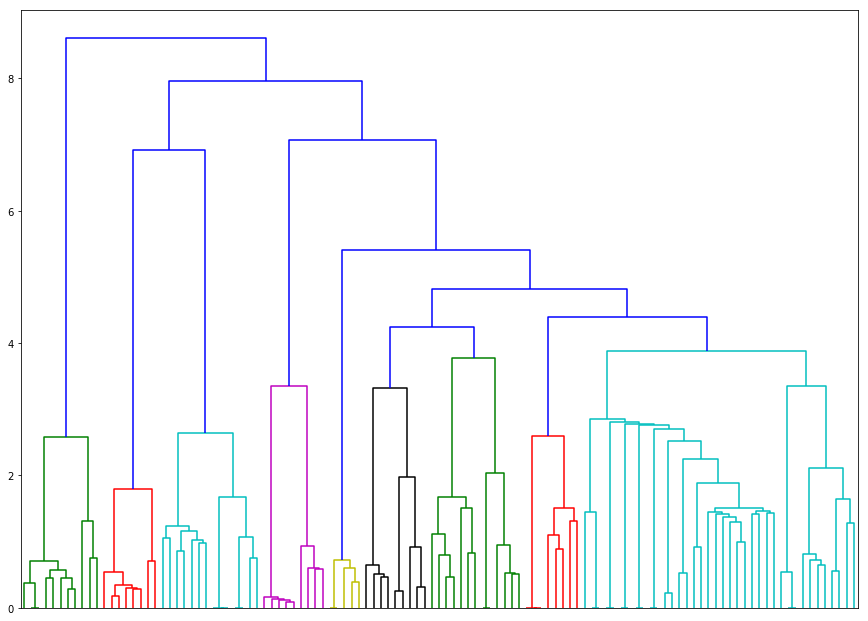

In [205]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(SS_sim_mat)
plt.figure(figsize=(15, 11))  
dd = dendrogram(linkage_matrix,  
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            no_labels=True,
            color_threshold=4) 
plt.show()  

In [198]:
G = 9

In [197]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=G, affinity='euclidean', linkage='ward')
cluster.fit_predict(SS_sim_mat) 
cluster.labels_

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 7, 0, 0, 7, 1, 7, 0, 1, 0,
       1, 6, 7, 4, 7, 2, 0, 6, 3, 4, 2, 3, 6, 7, 2, 3, 5, 6, 6, 3, 6, 4,
       1, 4, 5, 2, 2, 7, 4, 4, 6, 2, 7, 5, 3, 4, 7, 3, 5, 3, 2, 6, 6, 6,
       5, 2, 6, 2, 6, 4, 2, 2, 6, 2, 6, 3, 7, 7, 2, 3, 8, 0, 0, 0, 0, 0,
       8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 8, 8, 0,
       0, 0, 0, 0, 8])

In [203]:
from shutil import copyfile
os.mkdir('manual')

for i in range(G):
    os.mkdir(f'manual/G{i}')

for i,file in enumerate(manual_files):
    copyfile(file,'manual/G'+str(cluster.labels_[i])+'/'+file.split('/')[-1])
    

In [215]:
# create template excel files to start manual work
for i in range(G):
    temp = [f for j,f in enumerate(manual_files) if cluster.labels_[j] == i]
    DL = []
    for f in temp:
        D = []
        if 'ocr' in f:
            D.append(re.findall('/(\d*?)_',f)[0])
            D.append(re.findall('_(.*?)\.pdf',f)[0])
        else:
            D.append(f.split('/')[1])
            D.append(f.split('/')[2])
        D += [np.nan]*17
        D.append('手動處理！！加油！！')
        DL.append(D)
    pd.DataFrame(DL,columns=columns).to_excel(f'manual/G{i}/template_G{i}.xlsx',index=False)

In [211]:
manual_files

['CAAC審查資料PDF/150122/10176605/10176605.pdf',
 'CAAC審查資料PDF/150122/10274417/10274417.pdf',
 'CAAC審查資料PDF/150152/10146224/10146224.pdf',
 'CAAC審查資料PDF/150052/10130438/10130438.pdf',
 'CAAC審查資料PDF/150052/10045628/10045628.pdf',
 'CAAC審查資料PDF/150052/10048912/10048912.pdf',
 'CAAC審查資料PDF/150062/10256133/10256133.pdf',
 'CAAC審查資料PDF/150132/10130438/10130438.pdf',
 'CAAC審查資料PDF/150132/10262115/10262115.pdf',
 'CAAC審查資料PDF/150132/10146210/10146210.pdf',
 'CAAC審查資料PDF/150132/10146724/10146724.pdf',
 'CAAC審查資料PDF/150132/10256133/10256133.pdf',
 'CAAC審查資料PDF/150022/10199731/10199731.pdf',
 'CAAC審查資料PDF/150022/10303801/10303801.pdf',
 'CAAC審查資料PDF/150102/10251016/10251016.pdf',
 'CAAC審查資料PDF/150102/10200918/10200918.pdf',
 'CAAC審查資料PDF/150082/10152038/10152038.pdf',
 'CAAC審查資料PDF/150082/10146620/10146620.pdf',
 'CAAC審查資料PDF/150082/10267823/10267823.pdf',
 'CAAC審查資料PDF/150012/10232314/10232314.pdf',
 'CAAC審查資料PDF/150012/10146434/10146434.pdf',
 'CAAC審查資料PDF/150092/10233037/10233037.pdf',
 'CAAC審查資料

In [212]:
re.findall('/(\d*?)_','ocr/processed/150042_10122630.pdf')[0]

'150042'